<a href="https://colab.research.google.com/github/CrazyAncestor/DM_Neutrino_Flux/blob/master/BDM_Flux_Vegas_Newest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as opt
!pip install vegas
import vegas

     |████████████████████████████████| 1.3 MB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 42.0 MB/s 
  Created wheel for vegas: filename=vegas-5.1.1-cp37-cp37m-linux_x86_64.whl size=1501858 sha256=4f14699c05a9a10228446ca8c97a2f93fbc069ccd31cd195ebf4ef582824f94f
  Stored in directory: /root/.cache/pip/wheels/5c/e4/05/3bcde90bc37d2c2b77a85b376b36926daee5516139fa9cd610
  Created wheel for gvar: filename=gvar-11.9.5-cp37-cp37m-linux_x86_64.whl size=3932967 sha256=11f7ce5212ee22568e1af670fdc759bce815b419273376ffda8b5dbe2ce12189
  Stored in directory: /root/.cache/pip/wheels/74/6d/86/61d8c751b1a5cb7a3ec8b31659442208a8fc07fb1632fc61dc
Successfully built vegas gvar


In [2]:
# Global constants
# light speed, cm
c = 3*1e10
# kpc to cm
kpc2cm = 3.08*1e21
# erg to MeV
erg2MeV = 624150.913
# year in seconds
yr = 31536000
# Neutrino lumonisity, single specie
Lv = 3e52/6

# **SN neutrino and DM halo profile**
The neutrino number density per energy
$\frac{dn_\nu}{dE_\nu}(r,E_\nu) = \sum_\beta \frac{L_{\nu_{\beta}}}{4\pi r^2 c \langle E_{\nu_\beta}\rangle}f_{\nu_\beta}(E_{\nu_\beta})$ \\
where $\beta$ indicates the neutrino flavor and
$f_{\nu_\beta}(E_{\nu_\beta}) = \frac{1}{F_2(\eta_\nu)}\frac{1}{T_{\nu_\beta}^3}\frac{E_{\nu_\beta}^2}{\exp(E_{\nu_\beta}/T_{\nu_\beta} -\eta_\nu)+1}$ \\
and in general $\eta_{\nu}=3$ for all flavor $\beta$ and $F_2(\eta_{\nu})\approx18.96$. \\
 \\
For Milky Way (MW), we adopt NFW DM density profile
$n_\chi(r)=\frac{\rho_\chi}{m_\chi}\frac{1}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}$ \\
where $\rho_\chi = 184\,{\rm MeV/cm}^3$ and $r_s=24.42\,{\rm kpc}$.
 \\
For Large Magellanic Cloud (LMC), we adopt Hernquist DM density profile
$n_\chi(r)=\frac{\rho_\chi}{m_\chi}\frac{1}{\frac{r}{r_s}(1+\frac{r}{r_s})^3}$ \\
where $\rho_\chi = 68\,{\rm MeV/cm}^3$ and $r_s=31.9\,{\rm kpc}$.


In [3]:
def dnvdEv(r,Ev,Lv=Lv):
    """
    Neutrino number density per energy at r
    
    Input
    ------
    Enu: Neutrino energy in MeV
    r: Distance to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s, total time is 10 second
    
    Output
    ------
    Neutrino flux at r: # per Enu per cm**3 per second
    """
    Lv = Lv*erg2MeV
    r = r*kpc2cm
    
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    L=Lv/(4*np.pi*r**2*c)
    return L*(nue_dist+nueb_dist+4*nux_dist)

def nx(r,mx,type='LMC'):
    """
    DM number density at r
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    rho: characteristic density, 184 MeV/cm^3 for Milky Way, 68 MeV/cm^3 for LMC
    rs: characteristic length, 24.42 kpc for Milky Way, 31.90 kpc for LMC
    type: density profile type, like NFW (Milky Way) or Hernquist (LMC) profile
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    if type=='MW':
        rho = 184
        rs = 24.42
        x = r/rs
        rho_num = rho/mx
        return rho_num/(x*(1+x)**2)
    elif type=='MW_Simplified':
        return 4488/mx
    elif type=='LMC':
        rho = 68
        rs = 31.9
        x = r/rs
        rho_num = rho/mx
        return rho_num/(x*(1+x)**3)

# **Upscattered DM emissivity** 
$j_\chi^N(r,T_\chi,\alpha)=\frac{dn_\chi}{dtdT_\chi d\Omega_\alpha}=\frac{dn_\chi}{dtdE_\nu d\Omega_\alpha}\frac{dE_\nu}{dT_\chi}=c\sigma_{\chi \nu}n_\chi(r)\frac{dn_\nu}{dE_\nu}g(\alpha,E_\nu)\frac{dE_\nu}{dT_\chi},$ \\
where $g(\alpha,E_\nu)$ is the angular distribution of the upscattered DM, $dT_\chi$ the upscattered DM kinetic energy and $\alpha$ the scattering angle. \\
The angluar distribution is given by
$g(\alpha,E_\nu)=\frac{dn_\chi}{d\Omega_\alpha}=\frac{\sin[2\tan^{-1}(\gamma \tan\alpha)]}{2\pi \sin\alpha}\frac{\gamma \sec^2\alpha}{1+\gamma^2\tan^2\alpha}=\frac{\gamma^2}{\pi}\frac{\sec^3\alpha}{(1+\gamma^2\tan^2\alpha)^2} = \frac{\gamma^2}{\pi}\frac{r^3\sqrt{r^2-R^2\sin^2\theta}}{(r^2+R^2(\gamma^2-1)\sin^2\theta)^2}$ \\
and satisfies the normalization condiation \\
$\int g(\alpha,E_\nu)d\cos\alpha d\phi =1$ \\
where $\alpha$ runs from $0$ to $\pi/2$ and $\gamma=E_\chi/m_\chi$. As a matter of fact, the above condition is irrelevant to $\gamma$. \\


**Find $E_\nu$ with given $T_\chi$ and $\alpha$** \\
$T_\chi = \frac{E_\nu^2}{E_\nu+m_\chi/2}\left(\frac{1+\cos\theta_c}{2}\right)$ \\
and \\
$\theta_c = 2\tan^{-1}(\gamma \tan\alpha)$ \\
Thus we have the differential \\
$\frac{dE_\nu}{dT_\chi}= \frac{m_{\chi}^{2}\sec\alpha(2\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}+2m_{\chi}+T_{\chi}\sec^{2}\alpha+T_{\chi})}{(T_{\chi}\tan^{2}\alpha-2m_{\chi})^2\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}=\frac{m_{\chi}^{2}\left(\frac{2\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}}{\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}}+2m_{\chi}+\frac{T_{\chi}}{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}+2T_{\chi}\right)}{\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}\left(\frac{R^{2}\sin^{2}\theta T_{\chi}}{r^{2}-R^{2}\sin^{2}\theta}-2m_{\chi}\right){}^{2}}$ \\


In [4]:
def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    if np.isnan((Ev + mx)/((mx**2+2*mx*Ev)**0.5)):
        print(Ev,mx,mx**2+2*mx*Ev)
    return (Ev + mx)/((mx**2+2*mx*Ev)**0.5)
def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution
    
    Input
    ------
    Ev: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """
    # From Wen-Hua's note
    if 0 <= alpha <= np.pi/2 and Ev>0: 
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
        return dndOmega
    else:
        return 0

def Tx(Ev,mx,alpha):
    """
    Calculate DM kinetic energy, Eq. (28), and velocity, Eq. (30),
    in terms of lab frame scattering angle
    
    Input
    ------
    Ev: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    Tx: DM kinetic energy at alpha after scattering
    """
    # gamma factor in CM frame
    gm = gamma(Ev,mx)
    # CM frame scattering angle
    theta_c = 2*np.arctan(gm*np.tan(alpha))
    
    # Tmax in lab frame
    Tmax = Ev**2/(Ev+0.5*mx)
    Tchi = 0.5*Tmax*(1+np.cos(theta_c))
    return Tchi


def Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame scattering angle alpha via analytical expression.
    Note that if Ev is negative then it is unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """
    sec = 1/np.cos(alpha)
    enu = (Tx*sec**2 + sec*np.sqrt(Tx*(2*mx + Tx)))/(2 - Tx*np.tan(alpha)**2/mx)
    return enu


def dEvdTx(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    dTx: arbitrarity small number, default 1e-5
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def vx(Tx,mx):
    """
    The dimensionless DM velocity. To restore the physical unit, just
    times the speed of light c
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    
    Output
    ------
    vx: dimensionless DM velocity
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)

def xemissivity(Tx,mx,alpha,r,Lv=Lv,type='LMC'):
    """
    Upscattered DM emissivity, note the returned result is divided by sigxv and light velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    vx: the DM dimensionless velocity in terms of Tx and mx
    r: the distance from the scattering point to GC, kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    Enu = Ev(Tx,mx,alpha)
    
    if alpha!=0.:
        if Tx < 2*mx/np.tan(alpha)**2 and Enu >= 0:    
            dEdT = dEvdTx(Tx,mx,alpha)
            jx = dnvdEv(r,Enu,Lv)*c *nx(r,mx,type=type)*g(Enu,mx,alpha)*dEdT
        else:
            jx = 0
    else:
        jx = 0
    return jx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


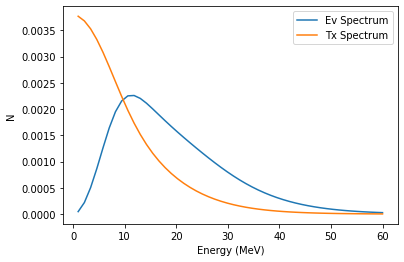

In [5]:
def dNdEv(Ev):
        
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    return (nue_dist+nueb_dist+4*nux_dist)

alpha = np.linspace(0,np.pi/2.,100)
Txs = np.linspace(1,60,50)
Evs = np.linspace(1,60,50)
mx = 1e-2
g_Tx = []
g_Ev = []

for j in range(len(Txs)):
  N = 0.
  def f(a):
    _Ev = Ev(Txs[j],mx,a)
    if (_Ev>0)==False:
      return 0
    return dNdEv(_Ev)*dEvdTx(Txs[j],mx,a)*g(_Ev,mx,a)*np.sin(a)
  N = integrate.quad(f,0,np.pi/2.)[0]
  g_Tx.append(N)

for j in range(len(Evs)):
  N = 0.
  def f(a):
    return dNdEv(Evs[j])*g(Evs[j],mx,a)*np.sin(a)
  N = integrate.quad(f,0,np.pi/2.)[0]
  g_Ev.append(N)

plt.plot(Evs, g_Ev,label='Ev Spectrum')
plt.plot(Txs, g_Tx,label='Tx Spectrum')

plt.xlabel('Energy (MeV)')
plt.ylabel('N ')
plt.legend(loc='best')

In [6]:
print(np.sum(Evs*g_Ev)/np.sum(g_Ev))
print(np.sum(Txs*g_Tx)/np.sum(g_Tx))

18.955724083275214
9.845193920613458


In [7]:
def Root_Finding(theta, t,vx,R = 50,r_cut=1e-6):
    """
    Find l, r and alpha when t, cos\theta, R and vx are given
    
    Input
    ------
    t: timing in seconds, 0 starts from the first arrival of the SN neutrino at Earth
    theta: in rad
    vx: dimensionless DM velocity, v/c
    R: R in kpc, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    tuple: (l,r,alpha,flag)
           flag is a string label, physical/unphysical, where unphysical
           result should be considered zero contribution to the emissivity
    """
    cos = np.cos(theta)
    zeta = c*t/kpc2cm + R
    k = zeta/R
    l = (-2*zeta*vx+2*cos*R*vx**2 + np.sqrt(vx**2*(2*zeta-2*cos*R*vx)**2 + 4*(-R**2+zeta**2)*vx**2*(-1+vx**2)))/(2*(-1+vx**2))
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vx-1)
    
    r = 0.0
    if l**2 + R**2 - 2*l*R*cos<0.:
        r = 0.0
    else:
        r = np.sqrt(l**2 + R**2 - 2*l*R*cos)
    
    alpha = 0.0

    if r>0 and l>0.:
        if (R**2-r**2-l**2)/(2*r*l)>1.0:
            alpha = 0.0
        elif (R**2-r**2-l**2)/(2*r*l)<-1.0:
            alpha = np.pi
        else:
            alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
        if(np.isnan(alpha)):
            print(r,l,(R**2-r**2-l**2)/(2*r*l))
    else:
        alpha = 0.0
    # Avoid Unphysical Geometry

    if l > 0 and r > 0 and r > r_cut and 0 <= alpha <= 0.5*np.pi:
        flag = 'physical'
    else:
        flag = 'unphysical'

    return l,r,alpha,flag

The upscattered DM flux is given by \\
$\frac{d\Phi^{N}(T_{\chi},t)}{dT_{\chi}dt}=2\pi \mathcal{J}\tau\int_{\cos\theta_{{\rm min}}}^{\cos\theta_{{\rm max}}}d\cos\theta \left. j_{\chi}^{N}(r,T_{\chi},\alpha)\right|_{\frac{r}{c}+\frac{\ell}{v_{\chi}}=t}$
where $\theta \in [0,\pi/2]$ and $\mathcal{J}$ is a Jacobian. \\
$d\left(\frac{r}{c}+\frac{\ell}{v_\chi}\right)=dt\to \left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)d\ell = dt,$ \\
Thus, \\
$\mathcal{J}=\left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)^{-1}.$


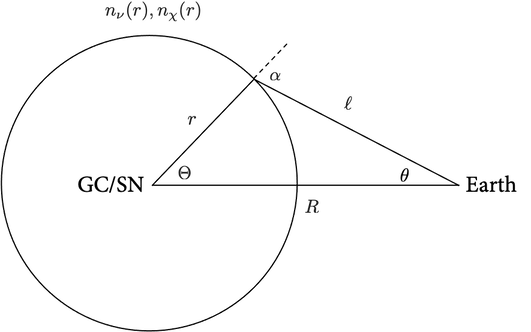

# **Simplified expression for $\ell$**
We can have more simplified expression for $\ell$ with \\
$r + \frac{\ell}{v_\chi} = ct \equiv\zeta$ \\
where $r$, $\ell$ and $\zeta$ are in kpc and 
$v_\chi$ is dimensionless velocity. Thus, \\
$\ell = \frac{-\sqrt{4 \left(\zeta ^2-R^2\right) \left(v_{\chi }^2-1\right) v_{\chi }^2+v_{\chi }^2 \left(2 \zeta -2 R \cos \theta  v_{\chi }\right){}^2}+2 R \cos \theta  v_{\chi }^2-2 \zeta  v_{\chi }}{2 \left(v_{\chi }^2-1\right)}.$
Note that $t$ is the total propagation time timing from the upscattering point. \\



In [8]:
def bdmflux(t,Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.0,r_cut=1e-6,type='LMC'):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """

    # find DM velocity
    beta = vx(Tx,mx)

    def f(theta): 
        l,r,alpha,flag = Root_Finding(theta,t,beta,R,r_cut) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,Lv,type=type)
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    
    result = integrate.quad(f,0.1,np.pi/2)[0]
    result += integrate.quad(f,0.01,0.1)[0]
    result += integrate.quad(f,0.001,0.01)[0]
    result += integrate.quad(f,0.0001,0.001)[0]
    result += integrate.quad(f,0.00001,0.0001)[0]
    result += integrate.quad(f,1e-6,0.00001)[0]
    result += integrate.quad(f,0,1e-6)[0]
    
    return result*beta*c

In [9]:
def Jacobian_Quad(f,a,b):
  ua = np.log(a)
  ub = np.log(b)
  def s(z):
    return f(np.exp(z))*np.exp(z)
  return integrate.quad(s,ua,ub)[0]
def Get_Theta_Crit(f,a,b):
  thetas = np.logspace(np.log10(a),np.log10(b),10)
  fs = []
  for i in range(len(thetas)):
    fs.append(f(thetas[i]))
  idx = np.argmax(fs)
  return thetas[idx]

def bdmflux_new(t,Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.0,r_cut=1e-6,type='LMC'):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """    
    # find DM velocity
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)

    def f(theta): 
        l,r,alpha,flag = Root_Finding(theta,t,beta,R,r_cut) # solve geometry
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,Lv,type=type)
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    theta_crit = Get_Theta_Crit(f,1e-8,np.pi/2.)
    result = Jacobian_Quad(f,theta_crit,np.pi/2)
    result += Jacobian_Quad(f,0.1*theta_crit,theta_crit)
    result += integrate.quad(f,0.,0.1*theta_crit)[0]

    return result*beta*c

In [ ]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx = 10

# years
yrls=np.logspace(-6,3,1000)

fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux_new(y*yr,Tx,mx1))

fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_new(y*yr,Tx,mx2))

fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux_new(y*yr,Tx,mx3))

fluxmx4_20=[]
for y in yrls:
    fluxmx4_20.append(bdmflux_new(y*yr,Tx,mx4))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


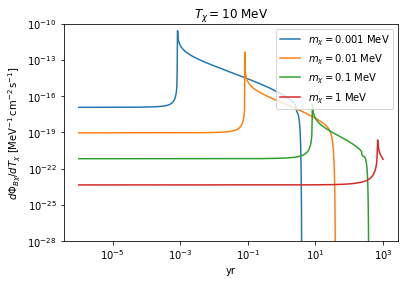

In [ ]:
plt.plot(yrls,fluxmx1_20,label='$m_\chi=$' +str(mx1)+' MeV')
plt.plot(yrls,fluxmx2_20,label='$m_\chi=$' +str(mx2)+' MeV')
plt.plot(yrls,fluxmx3_20,label='$m_\chi=$' +str(mx3)+' MeV')
plt.plot(yrls,fluxmx4_20,label='$m_\chi=$' +str(mx4)+' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi_{B\chi}/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx)+' MeV')
plt.legend(loc='best')
plt.ylim(1e-28,1e-10)
plt.savefig('time_dependent_flux_10MeV.pdf',facecolor='white',bbox_inches='tight')
plt.show()

In [ ]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx = 10

# years
yrls=np.logspace(-6,3,1000)

fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux_new(y*yr,Tx,mx1))

fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_new(y*yr,Tx,mx2))

fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux_new(y*yr,Tx,mx3))

"""fluxmx4_20=[]
for y in yrls:
    fluxmx4_20.append(bdmflux_new(y*yr,Tx,mx4))"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


'fluxmx4_20=[]\nfor y in yrls:\n    fluxmx4_20.append(bdmflux_new(y*yr,Tx,mx4))'

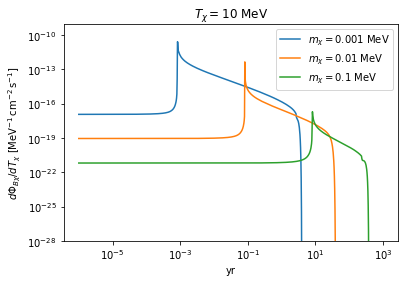

In [ ]:
plt.plot(yrls,fluxmx1_20,label='$m_\chi=$' +str(mx1)+' MeV')
plt.plot(yrls,fluxmx2_20,label='$m_\chi=$' +str(mx2)+' MeV')
plt.plot(yrls,fluxmx3_20,label='$m_\chi=$' +str(mx3)+' MeV')
"""plt.plot(yrls,fluxmx4_20,label='$m_\chi=$' +str(mx4)+' MeV')"""
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi_{B\chi}/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx)+' MeV')
plt.legend(loc='best')
plt.ylim(1e-28,1e-9)
plt.savefig('time_dependent_flux_10MeV.pdf',facecolor='white',bbox_inches='tight')
plt.show()

In [82]:
def Vegas_Jacobian_Integration(f,a,b):
    ua = np.log(a)
    ub = np.log(b)
    def fg(z):
        return f([np.exp(z[0])])*np.exp(z[0])
    integ = vegas.Integrator([[ua, ub]])
    result = integ(fg, nitn=1, neval=1000)

    return result.mean

def VJI(f,a,b,inv=False,eval_num=1000):
  if inv==False:
    ua = np.log(a)
    ub = np.log(b)
    def fg(z):
        return f([np.exp(z[0])])*np.exp(z[0])
    integ = vegas.Integrator([[ua, ub]])
    result = integ(fg, nitn=1, neval=eval_num)

    return result.mean
  if inv==True:
    ua = -np.log(a)
    ub = -np.log(b)
    def fg(z):
        return f([np.exp(-z[0])])*np.exp(-z[0])
    integ = vegas.Integrator([[ub, ua]])
    result = integ(fg, nitn=1, neval=eval_num)

    return result.mean

def bdmflux_vegas(t,Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.0,r_cut=1e-6,type='LMC'):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    
    # find DM velocity
    beta = vx(Tx,mx)

    def f(theta): 
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta[0],t,beta,R,r_cut=r_cut) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta[0]) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,Lv,type=type)
        physical_terms /= (l-R*np.cos(theta[0]))/r*beta+1
        
        return geometric_terms*physical_terms
    def Get_Theta_Crit_Vegas(f,a,b):
        thetas = np.logspace(np.log10(a),np.log10(b),10)
        fs = []
        for i in range(len(thetas)):
            fs.append(f([thetas[i]]))
        idx = np.argmax(fs)
        return thetas[idx]

    theta_crit = Get_Theta_Crit_Vegas(f,1e-8,np.pi/2.)
    result = VJI(f,theta_crit, np.pi/2.,eval_num=100)
    result += VJI(f,1e-8, theta_crit,inv=True,eval_num=100)
    return result*beta*c

    result = Vegas_Jacobian_Integration(f,theta_crit, np.pi/2.)
    result += Vegas_Jacobian_Integration(f,1e-8, theta_crit)
    return result*beta*c


In [63]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx = 10
# years
yrls=np.logspace(-6,3,100)

fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux_vegas(y*yr,Tx,mx1))

fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_vegas(y*yr,Tx,mx2))
    
fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux_vegas(y*yr,Tx,mx3))

"""fluxmx4_20=[]
for y in yrls:
    fluxmx4_20.append(bdmflux_vegas(y*yr,Tx,mx4))"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


'fluxmx4_20=[]\nfor y in yrls:\n    fluxmx4_20.append(bdmflux_vegas(y*yr,Tx,mx4))'

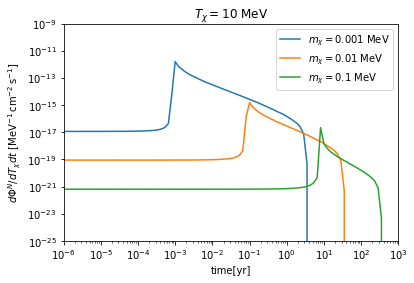

In [64]:
#plt.figure(dpi=400)
plt.plot(yrls,fluxmx1_20,label='$m_\chi=$'+str(mx1)+' MeV')
plt.plot(yrls,fluxmx2_20,label='$m_\chi=$' +str(mx2)+' MeV')
plt.plot(yrls,fluxmx3_20,label='$m_\chi=$' +str(mx3)+' MeV')
#plt.plot(yrls,fluxmx4_20,label='$m_\chi=$' +str(mx4)+' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time[yr]')
plt.ylabel(r'$d\Phi^{N}/dT_\chi dt~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx)+' MeV')
plt.legend(loc='best')
plt.xlim(1e-6,1e3)
plt.ylim(1e-25,1e-9)
#plt.savefig('time_dependent_flux_20MeV_2.pdf',facecolor='white',bbox_inches='tight')
plt.show()

In [ ]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1

# Time (Unit: Years)
t = np.logspace(-6.4989407377,np.log10(5),100)

# DM kinetic energy (Unit: MeV)
Tx = np.linspace(5,100,100)

x,y = np.meshgrid(t,Tx)

flux=[]
for i in range(len(x)):
  temp = []
  for j in range(len(x[0])):
    temp.append(bdmflux_vegas(x[i][j]*yr,y[i][j],mx1,r_cut=1e-3))
  flux.append(temp)
flux = np.array(flux)


"""fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux_vegas(y*yr,Tx,mx2))
    
fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux_vegas(y*yr,Tx,mx3))"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


'fluxmx2_20=[]\nfor y in yrls:\n    fluxmx2_20.append(bdmflux_vegas(y*yr,Tx,mx2))\n    \nfluxmx3_20=[]\nfor y in yrls:\n    fluxmx3_20.append(bdmflux_vegas(y*yr,Tx,mx3))'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


Text(0, 0.5, 'Tx (MeV)')

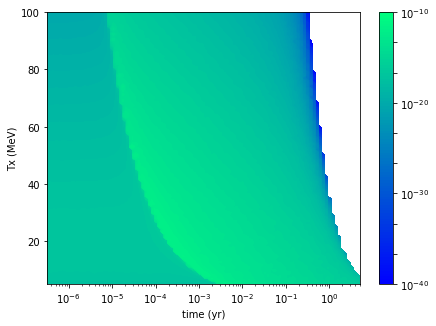

In [ ]:
from matplotlib import ticker, cm
lev_exp = np.linspace(-40,-10,100)
levs = np.power(10, lev_exp)
fig, axes = plt.subplots(figsize = (7,5))
C = axes.contourf(x, y, flux, levs,
				cmap = plt.cm.winter,
				origin = 'upper',locator=ticker.LogLocator())
fig.colorbar(C, ax=axes,ticks=np.logspace(-40,-10,10))
plt.xscale('log')
plt.xlabel('time (yr)')
plt.ylabel('Tx (MeV)')

In [ ]:
def Jacobian_Method(func,a,b,n):
  
  def gp(z):
    return func(np.exp(z))
  def Jacobian_Simpson_Method(func,a,b,n):
    dx = (b-a)/n
    sum = 0
    for i in range(n):
      sum += (func(a+i*dx) + 4*func(a+(i+1/2)*dx) + func(a+(i+1)*dx))/6*dx *np.exp(a+(i+1/2)*dx)
    return sum
  sum = Jacobian_Simpson_Method(gp,np.log(a),np.log(b),n)
  return sum
def Jacobian_dblQuad(f,a,b,c,d):
  ua = np.log(a)
  ub = np.log(b)
  uc = np.log(c)
  ud = np.log(d)
  def s(u,v):
    return f(np.exp(u),np.exp(v))*np.exp(u)*np.exp(v)
  return integrate.dblquad(s, uc, ud, lambda x: ua, lambda x: ub)[0]
def Special_dblQuad(f,theta1,theta2,t1,t2):
  utheta1 = np.log(theta1)
  utheta2 = np.log(theta2)
  ut1 = np.log(t1)
  ut2 = np.log(t2)
  
  def s(u,v):
    return f(np.exp(u),np.exp(v))*np.exp(u)*np.exp(v)
  def Get_Theta_at_T(ut):
    t = np.exp(ut)
    thetas = np.logspace(-8,np.log10(np.pi/2.),10)
    fs = []
    for i in range(len(thetas)):
      fs.append(f(thetas[i],t))
    idx = np.argmax(fs)
    return np.log(thetas[idx])
  
  result = integrate.dblquad(s, ut1, ut2, lambda ut: Get_Theta_at_T(ut), lambda ut: utheta2)[0]
  result += integrate.dblquad(s, ut1, ut2, lambda ut: Get_Theta_at_T(ut)-np.log(10), lambda ut: Get_Theta_at_T(ut))[0]
  result += integrate.dblquad(f, t1, t2, lambda ut: 0., lambda ut: np.exp(Get_Theta_at_T(ut)-np.log(10)))[0]
  return result
def Vegas_Jacobian_dblIntegration(f,a,b,c,d):
    ua = np.log(a)
    ub = np.log(b)
    uc = np.log(c)
    ud = np.log(d)
    def g(z):
        return f([np.exp(z[0]),np.exp(z[1])])*np.exp(z[0])*np.exp(z[1])
    integ = vegas.Integrator([[ua, ub],[uc, ud]])
    result = integ(g, nitn=1, neval=10000)
    return result.mean
def Accumulated_bdmnumber(Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.,r_cut=1e-6):
    def f(t):
        return bdmflux(t,Tx,mx,tau,sigxv,Lv,R,r_cut)
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vdm-1)
    tmax = np.min([t_crit*10**(1-np.log10(mx)),30*yr])
    return integrate.quad(f,0,tmax)[0]


def Accumulated_bdmnumber_new(Tx,mx,sigxv=1e-45,tau=10,Lv=Lv,R=50.,r_cut=1e-6):
    
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)
    tmax = t_crit*10**(1-np.log10(mx))
    def f(theta,t): 
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R) # solve geometry     
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,Lv,type='LMC')
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    #return (Jacobian_dblQuad(f,1e-8,np.pi/2.,t_crit*1e-3,tmax))*beta*c
    return (Special_dblQuad(f,1e-8,np.pi/2.,t_crit*1e-3,tmax))*beta*c

def Accumulated_bdmnumber_vegas(Tx,mx,sigxv=1e-45,tau=10,Lv=Lv,R=50.,r_cut=1e-6):
    
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)
    tmax = t_crit*10**(1-np.log10(mx))
    def f(para):
        theta = para[0]
        t     = para[1]
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,Lv,type='LMC')
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    
    result = Vegas_Jacobian_dblIntegration(f,1e-5,np.pi/2.,t_crit,tmax)
    result += Vegas_Jacobian_dblIntegration(f,1e-8,1e-5,t_crit,tmax)
    result += Vegas_Jacobian_dblIntegration(f,1e-5,np.pi/2.,t_crit*1e-3,t_crit)
    result += Vegas_Jacobian_dblIntegration(f,1e-8,1e-5,t_crit*1e-3,t_crit)

    return result*beta*c


In [79]:
def Jacobian_Method(func,a,b,n):
  
  def gp(z):
    return func(np.exp(z))
  def Jacobian_Simpson_Method(func,a,b,n):
    dx = (b-a)/n
    sum = 0
    for i in range(n):
      sum += (func(a+i*dx) + 4*func(a+(i+1/2)*dx) + func(a+(i+1)*dx))/6*dx *np.exp(a+(i+1/2)*dx)
    return sum
  sum = Jacobian_Simpson_Method(gp,np.log(a),np.log(b),n)
  return sum
def Jacobian_dblQuad(f,a,b,c,d):
  ua = np.log(a)
  ub = np.log(b)
  uc = np.log(c)
  ud = np.log(d)
  def s(u,v):
    return f(np.exp(u),np.exp(v))*np.exp(u)*np.exp(v)
  return integrate.dblquad(s, uc, ud, lambda x: ua, lambda x: ub)[0]
def Special_dblQuad(f,theta1,theta2,t1,t2):
  utheta1 = np.log(theta1)
  utheta2 = np.log(theta2)
  ut1 = np.log(t1)
  ut2 = np.log(t2)
  
  def s(u,v):
    return f(np.exp(u),np.exp(v))*np.exp(u)*np.exp(v)
  def Get_Theta_at_T(ut):
    t = np.exp(ut)
    thetas = np.logspace(-8,np.log10(np.pi/2.),10)
    fs = []
    for i in range(len(thetas)):
      fs.append(f(thetas[i],t))
    idx = np.argmax(fs)
    return np.log(thetas[idx])
  
  result = integrate.dblquad(s, ut1, ut2, lambda ut: Get_Theta_at_T(ut), lambda ut: utheta2)[0]
  result += integrate.dblquad(s, ut1, ut2, lambda ut: Get_Theta_at_T(ut)-np.log(10), lambda ut: Get_Theta_at_T(ut))[0]
  result += integrate.dblquad(f, t1, t2, lambda ut: 0., lambda ut: np.exp(Get_Theta_at_T(ut)-np.log(10)))[0]
  return result
def Vegas_Jacobian_dblIntegration(f,a,b,c,d):
    ua = np.log(a)
    ub = np.log(b)
    uc = np.log(c)
    ud = np.log(d)
    def g(z):
        return f([np.exp(z[0]),np.exp(z[1])])*np.exp(z[0])*np.exp(z[1])
    integ = vegas.Integrator([[ua, ub],[uc, ud]])
    result = integ(g, nitn=1, neval=10000)
    return result.mean

def VJDBI(f,a,b,c,d,invx=False,invy=False):
  sgnx=1
  sgny=1
  if invx==True:
    sgnx = -1
  if invy==True:
    sgny = -1

  ua = sgnx*np.log(a)
  ub = sgnx*np.log(b)
  uc = sgny*np.log(c)
  ud = sgny*np.log(d)
  def g(z):
      return sgnx*sgny*f([np.exp(sgnx*z[0]),np.exp(sgny*z[1])])*np.exp(sgnx*z[0])*np.exp(sgny*z[1])
  integ = vegas.Integrator([[ua, ub],[uc, ud]])
  result = integ(g, nitn=1, neval=100000)
  return result.mean

def Accumulated_bdmnumber(Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.,r_cut=1e-3):
    def f(t):
      result = bdmflux_vegas(t,Tx,mx,r_cut=r_cut)
      return result
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vdm-1)
    tmax = np.min([t_crit*10**(1-np.log10(mx)),30*yr])
    return Jacobian_Method(f,t_crit*1e-3,t_crit,100)
    return Jacobian_Method(f,t_crit,tmax,100)
    return integrate.quad(f,t_crit,tmax)[0]

def Jacobian_Quad(f,a,b):
  ua = np.log(a)
  ub = np.log(b)
  def s(z):
    return f(np.exp(z))*np.exp(z)
  return integrate.quad(s,ua,ub)[0]
def Accumulated_bdmnumber_int(Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.,r_cut=1e-3):
    def f(t):
      result = bdmflux_vegas(t,Tx,mx,r_cut=r_cut)
      return result
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vdm-1)
    tmax = np.min([t_crit*10**(1-np.log10(mx)),30*yr])
    return Jacobian_Quad(f,t_crit*1e-1,t_crit) + Jacobian_Quad(f,t_crit,t_crit*10) + Jacobian_Quad(f,t_crit*10,tmax)

def Accumulated_bdmnumber_dbl_vegas(Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.,r_cut=1e-3):
    beta = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/beta-1)
    tmax = t_crit*10**(1-np.log10(mx))
    def f(para):
        theta = para[0]
        t     = para[1]
        #return test.bdmflux_f(theta,t,R,Tx,mx)
        l,r,alpha,flag = Root_Finding(theta,t,beta,R) # solve geometry
        
        if flag == 'unphysical':
            return 0
        
        # Geometric Terms
        geometric_terms = np.sin(theta) *2*np.pi 

        # Physical terms
        physical_terms = sigxv*tau*xemissivity(Tx,mx,alpha,r,Lv)
        
        physical_terms /= (l-R*np.cos(theta))/r*beta+1
        
        return geometric_terms*physical_terms
    
    result = VJDBI(f,1e-5,np.pi/2.,t_crit,tmax)
    result += VJDBI(f,1e-8,1e-5,t_crit,tmax,invx=True)
    result += VJDBI(f,1e-5,np.pi/2.,t_crit*1e-3,t_crit,invy=True)
    result += VJDBI(f,1e-8,1e-5,t_crit*1e-3,t_crit,invx=True,invy=True)

    return result*beta*c


In [81]:
Accumulated_BDMflux_DBL_mx1 = []


Tx1=np.linspace(5,100,10)
mx1 = 1e-3
mx2 = 1e-2
mx3 = 1e-1


for i in range(len(Tx1)):
  Accumulated_BDMflux_DBL_mx1.append(Accumulated_bdmnumber_dbl_vegas(Tx1[i],mx1,r_cut=1e-3))
  print(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


KeyboardInterrupt: ignored

In [76]:
print(Accumulated_BDMflux_DBL_mx1)
Accumulated_BDMflux_DBL_mx1 = np.array(Accumulated_BDMflux_DBL_mx1)
Accumulated_BDMflux_DBL_mx1 = np.abs(Accumulated_BDMflux_DBL_mx1)

[-1.6789659802388925e-07, -7.993426945967516e-09, -3.401786008306053e-08, -0.00014933530854112955, -6.370523455249465e-09, -1.7544932494778558e-10, -9.276466291765794e-11, -3.161270829774242e-11, -1.58997321880819e-12, -1.5149055692407613e-09]


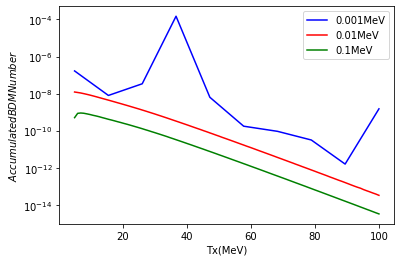

In [78]:
Accumulated_BDMflux_DBL_mx1Tx=np.linspace(5,100,100)
Accumulated_BDMflux_mx2 = get_data('accbdm_mx2.txt')
Accumulated_BDMflux_mx3 = get_data('accbdm_mx3.txt')
plt.plot(Tx1,Accumulated_BDMflux_DBL_mx1,color='blue',label=str(mx1)+'MeV')
plt.plot(Tx,Accumulated_BDMflux_mx2,color='red',label=str(mx2)+'MeV')
plt.plot(Tx,Accumulated_BDMflux_mx3,color='green',label=str(mx3)+'MeV')

#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
#plt.title(r'$m_\chi =$'+str(mx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('Tx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()

In [84]:
def VJI(f,a,b,inv=False,eval_num=1000):
  if inv==False:
    ua = np.log(a)
    ub = np.log(b)
    def fg(z):
        return f([np.exp(z[0])])*np.exp(z[0])
    integ = vegas.Integrator([[ua, ub]])
    result = integ(fg, nitn=1, neval=eval_num)

    return result.mean
  if inv==True:
    ua = -np.log(a)
    ub = -np.log(b)
    def fg(z):
        return f([np.exp(-z[0])])*np.exp(-z[0])
    integ = vegas.Integrator([[ub, ua]])
    result = integ(fg, nitn=1, neval=eval_num)

    return result.mean


def Jacobian_Quad(f,a,b,inv=False):
  if inv==False:
    ua = np.log(a)
    ub = np.log(b)
    def s(z):
      return f(np.exp(z))*np.exp(z)
    return integrate.quad(s,ua,ub)[0]
  if inv==True:
    ua = -np.log(a)
    ub = -np.log(b)
    def s(z):
      return f(np.exp(-z))*np.exp(-z)
    return integrate.quad(s,ub,ua)[0]

def Accumulated_bdmnumber_vegas(Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.,r_cut=1e-3):
    def f(time):
      ts = time[0]
      return  bdmflux_vegas(ts,Tx,mx,r_cut=r_cut)
    def g(time):
      ts = time
      return  bdmflux_vegas(ts,Tx,mx,r_cut=r_cut)
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vdm-1)
    tmax = np.min([t_crit*10**(1-np.log10(mx)),30*yr])

    """return Jacobian_Quad(g,t_crit*1e-3,t_crit*1e-1,inv=True)  \
    +Jacobian_Quad(g,t_crit*1e-1,t_crit*5e-1,inv=True) \
    +Jacobian_Quad(g,t_crit*5e-1,t_crit,inv=True) \
    + Jacobian_Quad(g,t_crit,t_crit*2) + Jacobian_Quad(g,t_crit*2,t_crit*10) \
    + Jacobian_Quad(g,t_crit*10,tmax)"""
    
    return VJI(f,t_crit*1e-3,t_crit*1e-1,inv=True,eval_num=100)  \
    +VJI(f,t_crit*1e-1,t_crit*5e-1,inv=True,eval_num=100) \
    +VJI(f,t_crit*5e-1,t_crit,inv=True,eval_num=100) \
    + VJI(f,t_crit,t_crit*2,eval_num=100) + VJI(f,t_crit*2,t_crit*10,eval_num=100) \
    + VJI(f,t_crit*10,tmax,eval_num=100)

Accumulated_BDMflux_mx1 = []


Tx1=np.linspace(5,100,20)
mx1 = 1e-3
mx2 = 1e-2
mx3 = 1e-1


for i in range(len(Tx1)):
  Accumulated_BDMflux_mx1.append(Accumulated_bdmnumber_vegas(Tx1[i],mx1,r_cut=1e-3))
  print(i)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


0
1
2
3
4
5
6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


7
8
9
10
11
12
13
14
15
16
17
18
19


In [31]:
from locale import atof
def get_data(filename):
  data = []
  with open(filename) as f:
    lines = f.readlines()
    for i in range(len(lines)):
      data.append(atof(lines[i]))
    return np.array(data)

In [ ]:
f = open("accbdm_mx1.txt", "a")
for i in range(len(Accumulated_BDMflux_mx1)):
  f.write(str(Accumulated_BDMflux_mx1[i])+'\n')
f.close()

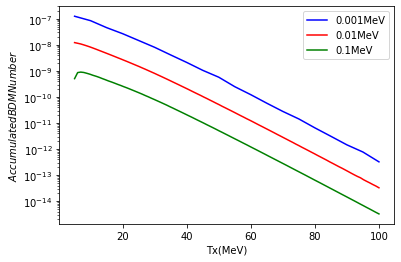

In [85]:
Tx=np.linspace(5,100,100)
Accumulated_BDMflux_mx2 = get_data('accbdm_mx2.txt')
Accumulated_BDMflux_mx3 = get_data('accbdm_mx3.txt')
plt.plot(Tx1,Accumulated_BDMflux_mx1,color='blue',label=str(mx1)+'MeV')
plt.plot(Tx,Accumulated_BDMflux_mx2,color='red',label=str(mx2)+'MeV')
plt.plot(Tx,Accumulated_BDMflux_mx3,color='green',label=str(mx3)+'MeV')

#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
#plt.title(r'$m_\chi =$'+str(mx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('Tx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()

In [ ]:
f = open("accbdm_mx1.txt", "a")
for i in range(len(Accumulated_BDMflux_mx1)):
  f.write(str(Accumulated_BDMflux_mx1[i])+'\n')
f.close()
f = open("accbdm_mx2.txt", "a")
for i in range(len(Accumulated_BDMflux_mx2)):
  f.write(str(Accumulated_BDMflux_mx2[i])+'\n')
f.close()
f = open("accbdm_mx3.txt", "a")
for i in range(len(Accumulated_BDMflux_mx3)):
  f.write(str(Accumulated_BDMflux_mx3[i])+'\n')
f.close()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


No handles with labels found to put in legend.


99


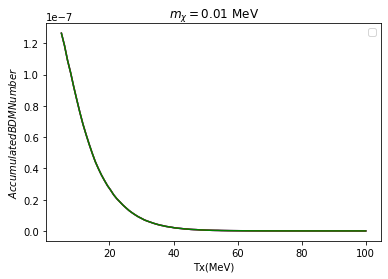

In [ ]:
Accumulated_BDMflux_mx1 = []
Accumulated_BDMflux_mx2 = []
Accumulated_BDMflux_mx3 = []

Tx=np.linspace(5,100,100)
mx1 = 1e-3
mx2 = 1e-2
mx3 = 1e-1

for i in range(len(Tx)):
  Accumulated_BDMflux_mx1.append(Accumulated_bdmnumber_int(Tx[i],mx1,r_cut=1e-3))
  Accumulated_BDMflux_mx2.append(Accumulated_bdmnumber_int(Tx[i],mx2,r_cut=1e-3))
  Accumulated_BDMflux_mx3.append(Accumulated_bdmnumber_int(Tx[i],mx3,r_cut=1e-3))
  print(i)


plt.plot(Tx,Accumulated_BDMflux_mx1,color='blue')
plt.plot(Tx,Accumulated_BDMflux_mx1,color='red')
plt.plot(Tx,Accumulated_BDMflux_mx1,color='green')

#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best')
plt.title(r'$m_\chi =$'+str(mx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('Tx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()

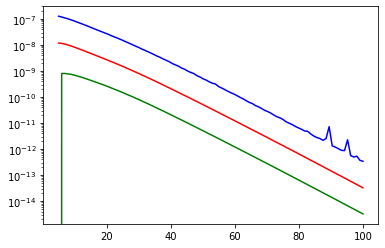

In [ ]:
plt.plot(Tx,Accumulated_BDMflux_mx1,color='blue')
plt.plot(Tx,Accumulated_BDMflux_mx2,color='red')
plt.plot(Tx,Accumulated_BDMflux_mx3,color='green')
plt.yscale('log')

In [ ]:
f = open("accbdm_mx1.txt", "a")
for i in range(len(Accumulated_BDMflux_mx1)):
  f.write(str(Accumulated_BDMflux_mx1[i])+'\n')
f.close()
f = open("accbdm_mx2.txt", "a")
for i in range(len(Accumulated_BDMflux_mx2)):
  f.write(str(Accumulated_BDMflux_mx2[i])+'\n')
f.close()
f = open("accbdm_mx3.txt", "a")
for i in range(len(Accumulated_BDMflux_mx3)):
  f.write(str(Accumulated_BDMflux_mx3[i])+'\n')
f.close()



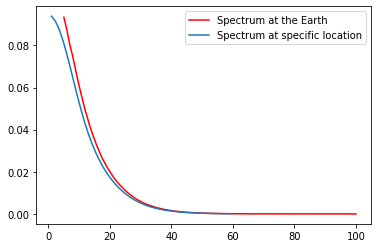

In [ ]:
def normailze(a):
  b = np.copy(a)
  const = np.sum(a)
  return b/const
plt.plot(Tx,normailze(Accumulated_BDMflux_mx1),color='red',label='Spectrum at the Earth')
plt.plot(Txs, normailze(g_Tx),label='Spectrum at specific location')
plt.legend(loc='best')

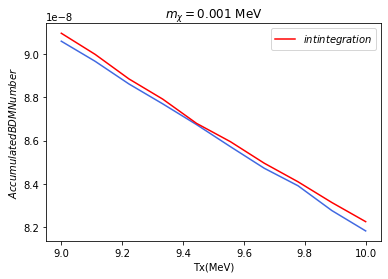

In [ ]:
plt.plot(Tx,Accumulated_BDMflux,color='royalblue')
plt.plot(Tx,Accumulated_BDMflux_int,color='red',label='$int integration$')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best')
plt.title(r'$m_\chi =$'+str(mx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('Tx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


0
1
2
3
4
5
6
7
8


No handles with labels found to put in legend.


9


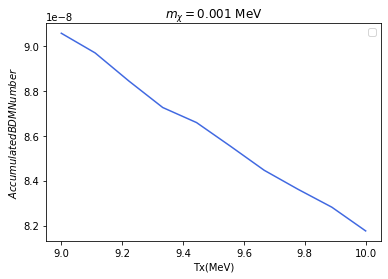

In [ ]:
def Accumulated_bdmnumber(Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=50.,r_cut=1e-3):
    def f(t):
      result = bdmflux_vegas(t,Tx,mx,r_cut=r_cut)
      return result
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    t_crit =  tv*(1/vdm-1)
    tmax = np.min([t_crit*10**(1-np.log10(mx)),30*yr])
    return Jacobian_Method(f,t_crit,tmax,50)+Jacobian_Method(f,t_crit*1e-3,t_crit,50)

  
Accumulated_BDMflux_q = []


Tx=np.linspace(9,10,10)
mx = 1e-3

for i in range(len(Tx)):
  Accumulated_BDMflux_q.append(Accumulated_bdmnumber(Tx[i],mx,r_cut=1e-3))
  #Accumulated_BDMflux_int.append(Accumulated_bdmnumber_int(Tx[i],mx,r_cut=1e-3))
  print(i)

plt.plot(Tx,Accumulated_BDMflux_q,color='royalblue')
#plt.plot(Tx,Accumulated_BDMflux_int,color='red')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best')
plt.title(r'$m_\chi =$'+str(mx)+' MeV')
#plt.ylim(1e-19,1e-7)
plt.xlabel('Tx(MeV)')
plt.ylabel(r'$Accumulated BDM Number$')
plt.show()

In [ ]:
print(Accumulated_BDMflux)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


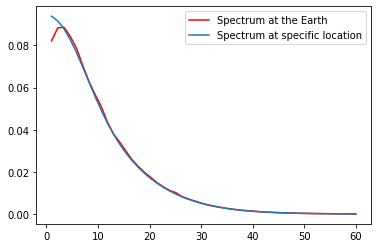

In [ ]:
def normailze(a):
  b = np.copy(a)
  const = np.sum(a)
  return b/const
plt.plot(Tx,normailze(Accumulated_BDMflux_vegas),color='red',label='Spectrum at the Earth')
plt.plot(Txs, normailze(g_Tx),label='Spectrum at specific location')
plt.legend(loc='best')

In [ ]:
print(np.sum(Accumulated_BDMflux))
print(np.sum(Accumulated_BDMflux_vegas))


7.672170385038367e-05
7.898664461715905e-05
